In [120]:
import math

import contextily as cx
import geopandas as gpd
import osmnx as ox
import pandas as pd
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon

BASEMAP_SOURCE = cx.providers.CartoDB.VoyagerNoLabels

ox.settings.use_cache = True
ox.settings.log_console = False

In [165]:
# get the boundaries of the place
tokyo_mp = ox.geocode_to_gdf(query={"city": "Tokyo"})
osaka = ox.geocode_to_gdf(query={"city": "Osaka"})
yokohama = ox.geocode_to_gdf(query={"city": "Yokohama"})
nagoya = ox.geocode_to_gdf(query={"city": "Nagoya"})
sapporo = ox.geocode_to_gdf(query={"city": "Sapporo"})

In [59]:
tokyo = gpd.GeoDataFrame(geometry=list(tokyo_mp.geometry[0].geoms), crs=4326).to_crs(
    3857
)
tokyo["area"] = tokyo["geometry"].area

<Axes: >

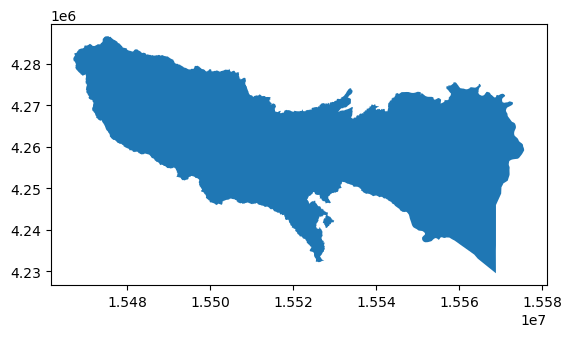

In [67]:
tokyo[tokyo["geometry"].centroid.y > 4150000]

In [20]:
data_url = "https://ndownloader.figshare.com/files/20232174"

db = gpd.read_file(data_url)

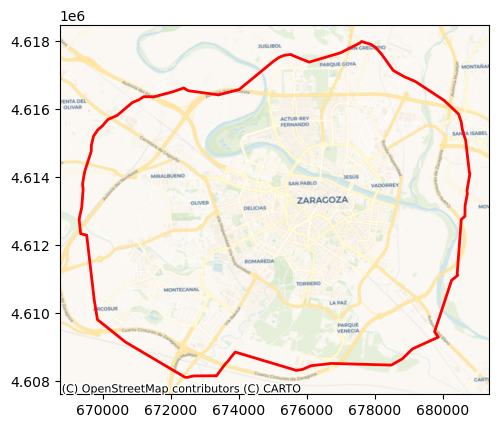

In [23]:
zaragoza = db.query("city_id == 'ci122'")
ax = zaragoza.plot(facecolor="none", edgecolor="red", linewidth=2)
cx.add_basemap(ax, crs=zaragoza.crs.to_string(), source=cx.providers.CartoDB.Voyager)

In [166]:
tokyo_poly = tokyo[tokyo["geometry"].centroid.y > 4150000].unary_union
tokyo_ml = gpd.GeoDataFrame(geometry=[tokyo_poly], crs=3857)

tokyo_extended = tokyo_ml.envelope.buffer(50_000)
yokohama_extended = yokohama.to_crs(3857).envelope.buffer(50_000)
osaka_extended = osaka.to_crs(3857).envelope.buffer(50_000)
nagoya_extended = nagoya.to_crs(3857).envelope.buffer(50_000)
sapporo_extended = sapporo.to_crs(3857).envelope.buffer(50_000)

In [98]:
def calculate_envelope_width_height(area: gpd.GeoDataFrame):
    width = area.geometry.bounds["maxx"][0] - area.geometry.bounds["minx"][0]
    height = area.geometry.bounds["maxy"][0] - area.geometry.bounds["miny"][0]
    return width, height

In [167]:
nw, nh = calculate_envelope_width_height(nagoya_extended)
ow, oh = calculate_envelope_width_height(osaka_extended)
yw, yh = calculate_envelope_width_height(yokohama_extended)
tw, th = calculate_envelope_width_height(tokyo_extended)
sw, sh = calculate_envelope_width_height(sapporo_extended)


max_width = math.ceil(max(ow, nw, yw, tw, sw))
max_height = math.ceil(max(oh, nh, yh, th, sh))
max_width, max_height

(208652, 162284)

In [142]:
def get_offsets(
    max_width: float, max_height: float, width: float, height: float
) -> tuple[float, float]:
    w_diff = (max_width - width) / 2
    h_diff = (max_width - height) / 2
    return w_diff, h_diff


def build_new_envelope(
    area: gpd.GeoDataFrame, w_diff: float, h_diff: float
) -> gpd.GeoDataFrame:
    minx = area.bounds["minx"][0] - w_diff
    maxx = area.bounds["maxx"][0] + w_diff
    miny = area.bounds["miny"][0] - h_diff
    maxy = area.bounds["maxy"][0] + h_diff
    p = Polygon(
        [Point(minx, miny), Point(maxx, miny), Point(maxx, maxy), Point(minx, maxy)]
    )
    return gpd.GeoDataFrame(geometry=[p], crs=3857)

In [168]:
nagoya_ne = build_new_envelope(
    nagoya_extended, *get_offsets(max_width, max_height, nw, nh)
)
osaka_ne = build_new_envelope(
    osaka_extended, *get_offsets(max_width, max_height, ow, oh)
)
yokohama_ne = build_new_envelope(
    yokohama_extended, *get_offsets(max_width, max_height, yw, yh)
)
tokyo_ne = build_new_envelope(
    tokyo_extended, *get_offsets(max_width, max_height, tw, th)
)
sapporo_ne = build_new_envelope(
    sapporo_extended, *get_offsets(max_width, max_height, sw, sh)
)

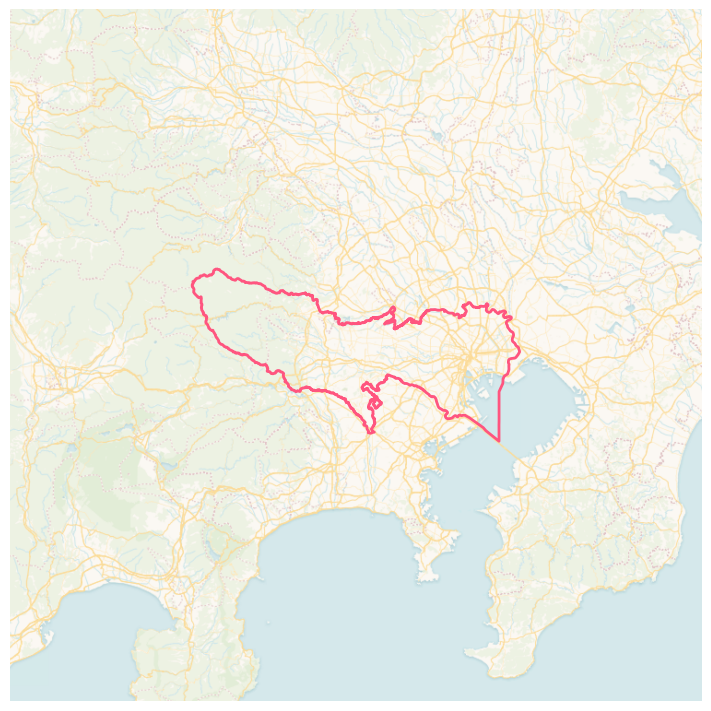

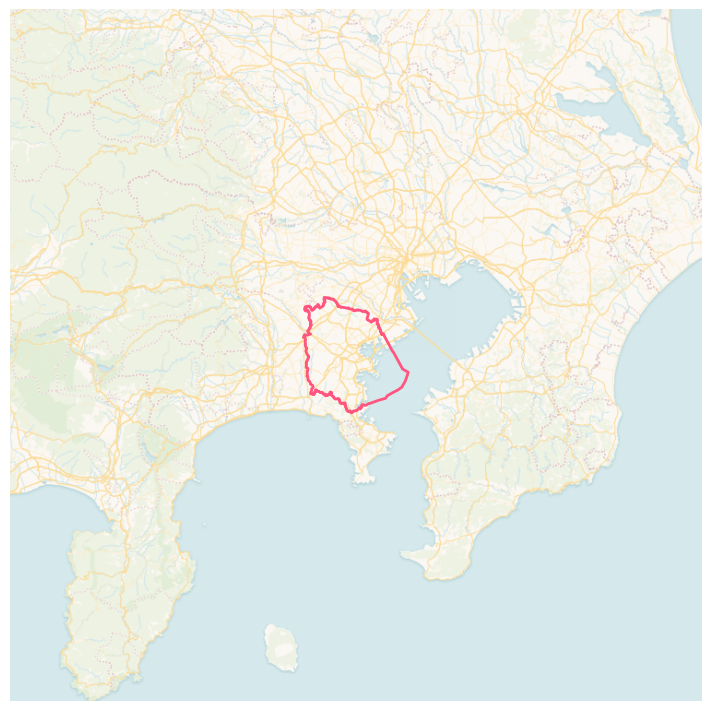

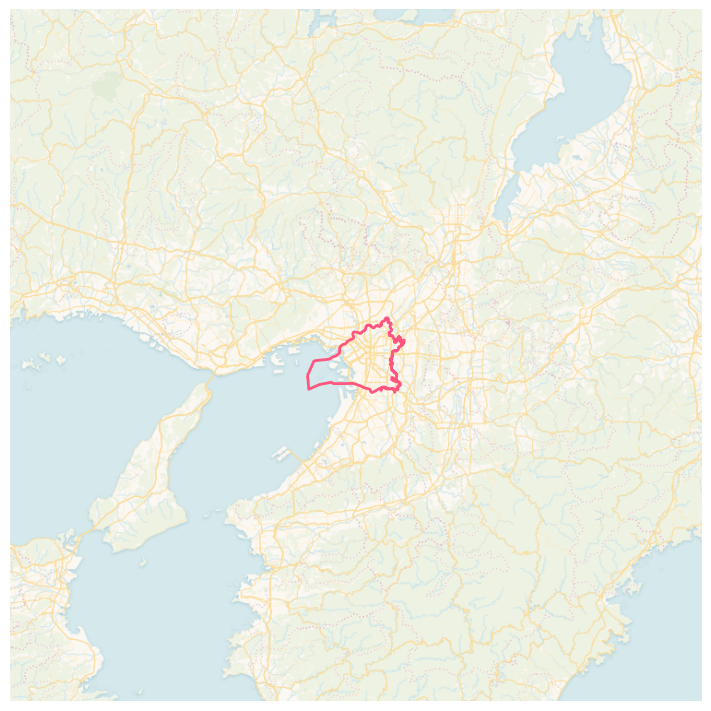

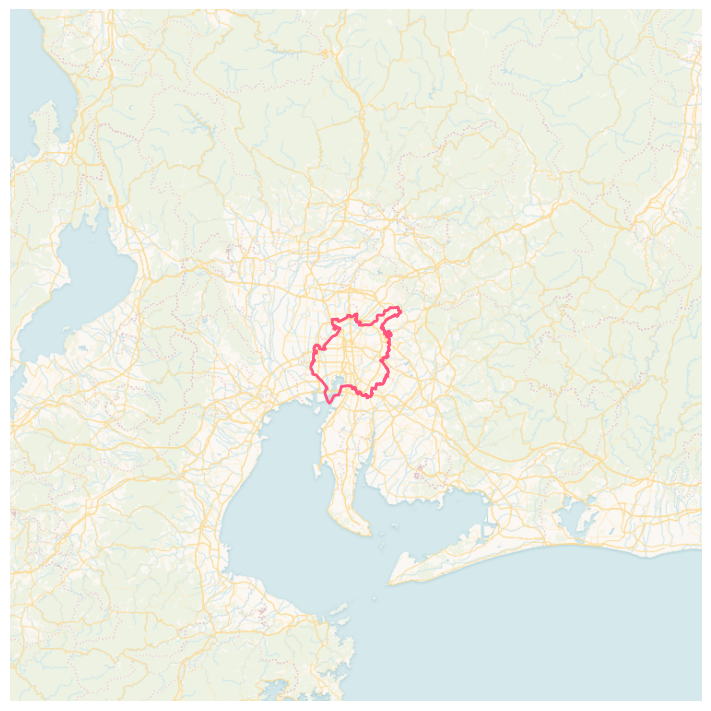

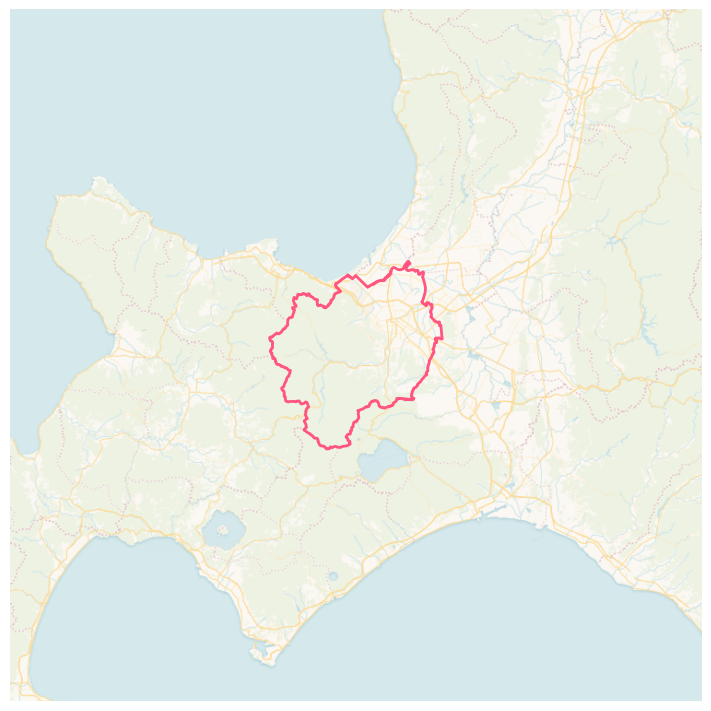

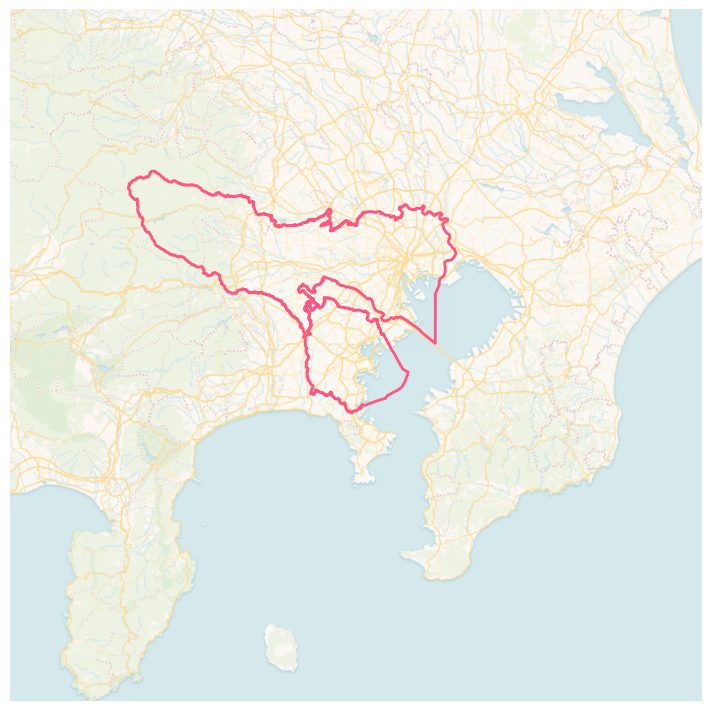

In [175]:
def plot_city(
    city: gpd.GeoDataFrame, area: gpd.GeoDataFrame, boundary_color: str = "#ff557f"
):
    fig, ax = plt.subplots(figsize=(7, 7), layout="constrained")
    area.plot(fc="none", ec="none", ax=ax)
    if boundary_color:
        city.to_crs(3857).plot(
            facecolor="none", edgecolor=boundary_color, linewidth=2, ax=ax
        )
    cx.add_basemap(
        ax,
        crs=area.crs.to_string(),
        source=cx.providers.CartoDB.VoyagerNoLabels,
        attribution=False,
    )
    ax.margins(0)
    ax.axis("off")
    return fig, ax


fig_t, _ = plot_city(tokyo_ml, tokyo_ne)
fig_t.savefig(
    "../figures/tokyo.png",
    dpi=120,
    pad_inches=0,
)

fig_y, _ = plot_city(yokohama, yokohama_ne)
fig_y.savefig(
    "../figures/yokohama.png",
    dpi=120,
    pad_inches=0,
)

fig_o, _ = plot_city(osaka, osaka_ne)
fig_o.savefig(
    "../figures/osaka.png",
    dpi=120,
    pad_inches=0,
)

fig_n, _ = plot_city(nagoya, nagoya_ne)
fig_n.savefig(
    "../figures/nagoya.png",
    dpi=120,
    pad_inches=0,
)

fig_s, _ = plot_city(sapporo, sapporo_ne)
fig_s.savefig(
    "../figures/sapporo.png",
    dpi=120,
    pad_inches=0,
)

fig_ty, _ = plot_city(pd.concat([tokyo_ml, yokohama.to_crs(3857)]), yokohama_ne)
fig_ty.savefig(
    "../figures/tokyo_and_yokohama.png",
    dpi=120,
    pad_inches=0,
)